In [1]:
import json
import warnings

import scipy.signal
import scipy.fft
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import librosa

In [2]:
x, fs = librosa.load('../data/xeno-canto/audio/100032.mp3', sr=44100)

/Users/kevin/.pyenv/versions/chorus/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [3]:
# That warning is super annoying... and it happens every time. Ignore it.
warnings.filterwarnings('ignore', 'PySoundFile failed. Trying audioread instead.')

In [4]:
x.shape, fs

((452736,), 44100)

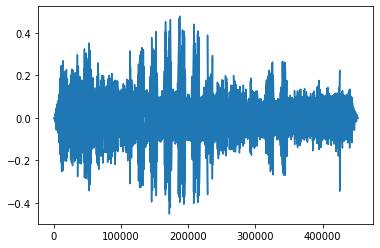

In [5]:
mpl.style.use('fast')
plt.plot(x)

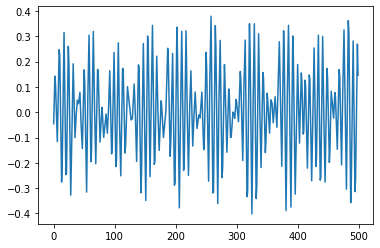

In [6]:
plt.plot(x[208_000:208_500])

In [7]:
def plot_spectrogram(xc_id, fs):
    """
    xc_id : xeno-canto id number
    fs    : target sampling rate when loading the file
    """
    x, fs = librosa.load(f'../data/xeno-canto/audio/{xc_id}.mp3', sr=fs)
    
    with open(f'../data/xeno-canto/meta/{xc_id}.json') as f:
        name = json.load(f)['en']
    
    # We'll use the hann window because Tensorflow doesnt support tukey
    f, t, Sxx = scipy.signal.spectrogram(x, fs=fs, nperseg=512, window='hann')
    
    fig, axs = plt.subplots(1, 2,
                            figsize=(12, 3),
                            sharey=True,
                            gridspec_kw={'width_ratios': [0.8, 0.2],
                                         'wspace': 0.05})
    
    axs[0].imshow(Sxx ** 0.1,  # exponentiating by 0.1 increases contrast
                  cmap='Greys',
                  origin='lower',
                  extent=[t.min(), t.max(), f.min(), f.max()],
                  aspect='auto')
    
    axs[1].plot(Sxx.mean(axis=1), f)
    
    axs[0].set_title(name)
    axs[0].set_ylabel('Frequency')
    axs[0].set_xlabel('Time (seconds)')
    
    axs[1].set_xlabel('Avg amplitude')
    axs[1].set_xscale('log')

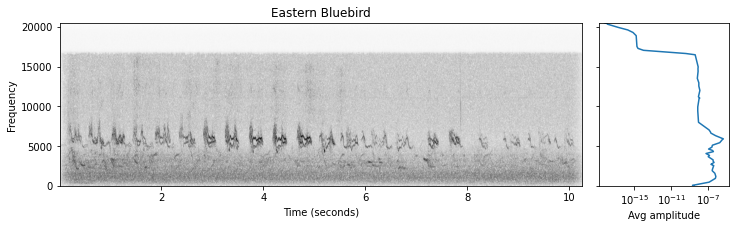

In [8]:
plot_spectrogram(100032, 41_000)

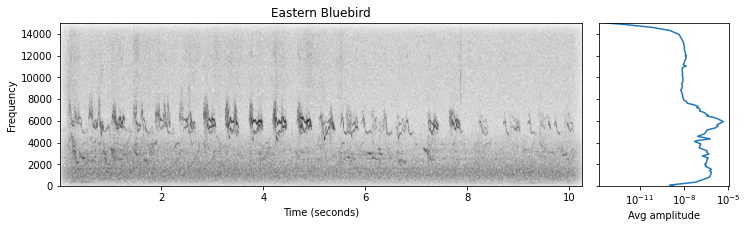

In [9]:
# It looks like there's a cutoff around the 16,000 frequency.
# Xeno-canto seems to use 15,000 as the cutoff for their spectrograms.
# To get that, we can set the sampling rate to 30,000 at load time.
plot_spectrogram(100032, 30_000)

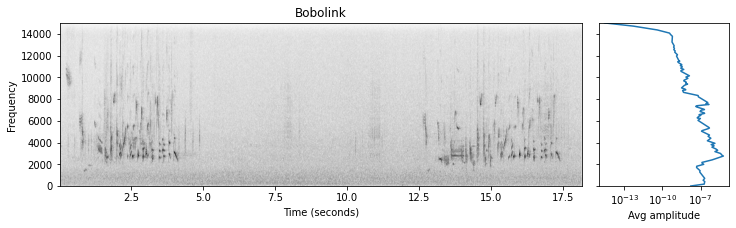

In [10]:
plot_spectrogram(100087, 30_000)

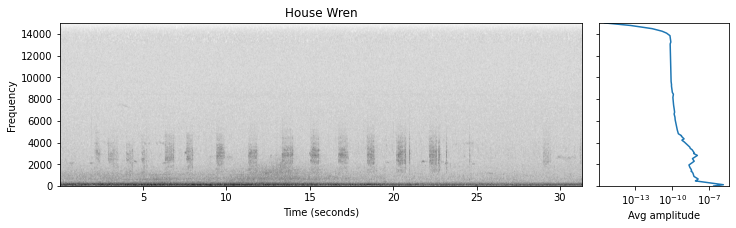

In [11]:
plot_spectrogram(347367, 30_000)

In [12]:
# Try to reproduce but with tensorflow ops
def plot_spectrogram_tf(xc_id, fs):
    """
    xc_id : xeno-canto id number
    fs    : target sampling rate when loading the file
    """
    x, fs = librosa.load(f'../data/xeno-canto/audio/{xc_id}.mp3', sr=fs)
    
    with open(f'../data/xeno-canto/meta/{xc_id}.json') as f:
        name = json.load(f)['en']
        
    f = scipy.fft.rfftfreq(512, 1 / fs)
    t = np.arange(0, x.shape[0] / fs, 1 / fs)
    
    Sxx = tf.signal.stft(x, 512, 512 - 512 // 8)
    Sxx = tf.abs(tf.math.conj(Sxx) * Sxx).numpy().T
    
    fig, axs = plt.subplots(1, 2,
                            figsize=(12, 3),
                            sharey=True,
                            gridspec_kw={'width_ratios': [0.8, 0.2],
                                         'wspace': 0.05})
    
    axs[0].imshow(Sxx ** 0.1,  # exponentiating by 0.1 increases contrast
                  cmap='Greys',
                  origin='lower',
                  extent=[t.min(), t.max(), f.min(), f.max()],
                  aspect='auto')
    
    axs[1].plot(Sxx.mean(axis=1), f)
    
    axs[0].set_title(name)
    axs[0].set_ylabel('Frequency')
    axs[0].set_xlabel('Time (seconds)')
    
    axs[1].set_xlabel('Avg amplitude')
    axs[1].set_xscale('log')

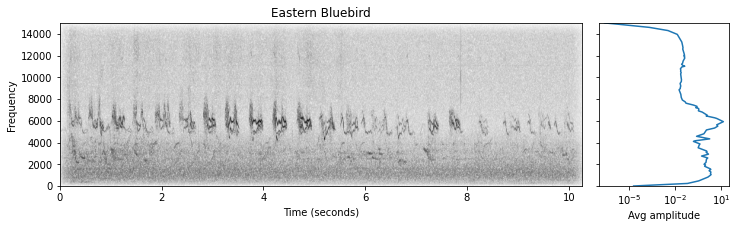

In [13]:
plot_spectrogram_tf(100032, 30_000)

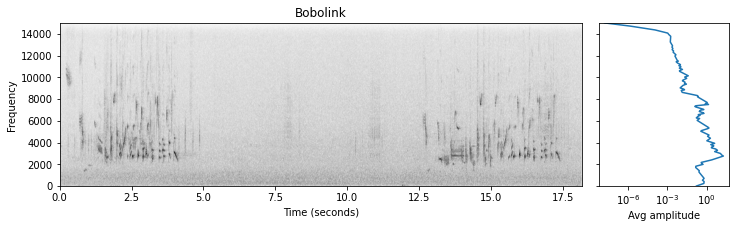

In [14]:
plot_spectrogram_tf(100087, 30_000)

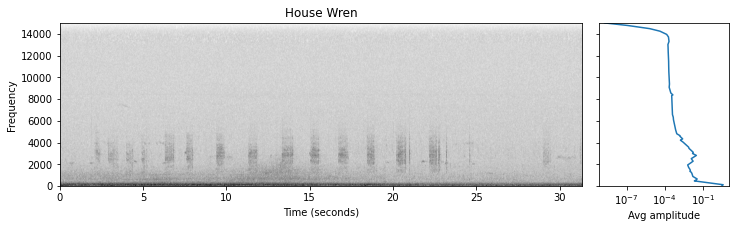

In [15]:
plot_spectrogram_tf(347367, 30_000)